<a href="https://colab.research.google.com/github/HMRLKE/adversarial-robustness-toolbox/blob/dependabot%2Fpip%2Fh5py-3.3.0/custom_transforms_for_adversarial_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow_addons
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install adversarial-robustness-toolbox

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-8s_723ff
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-8s_723ff
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794840 sha256=47478010d720018a3208703ead788e35c7b563923f6548e335bc4c1f943288dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0ol6cvq/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


In [3]:
import json

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.inception_v3 import InceptionV3

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

from art.classifiers import TensorFlowV2Classifier
from art.preprocessing.expectation_over_transformation import EoTImageRotationTensorFlow
from art.attacks.evasion import ProjectedGradientDescent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification
  del sys.path[0]


Prediction plots

In [4]:
def plot_prediction(img, probs, correct_class=None, target_class=None):

    # Initialize the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # Set the first plot to the input image
    fig.sca(ax1)
    ax1.imshow(img)

    # Determine the top ten labels and store them with their probabilities
    top_ten_indexes = list(probs[0].argsort()[-10:][::-1])
    top_probs = probs[0, top_ten_indexes]
    labels = [label_to_name(i) for i in top_ten_indexes]
    barlist = ax2.bar(range(10), top_probs)
    if target_class in top_ten_indexes:
        barlist[top_ten_indexes.index(target_class)].set_color('r')
    if correct_class in top_ten_indexes:
        barlist[top_ten_indexes.index(correct_class)].set_color('g')

    # Plot the probabilities and labels
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), labels, rotation='vertical')
    plt.ylabel("Probability")
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [ ]:
def eval_prediction(img, probs, correct_class=None, target_class=None):

    # Initialize the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # Set the first plot to the input image
    fig.sca(ax1)
    ax1.imshow(img)
    pred = max(probs)
    # Determine the top ten labels and store them with their probabilities
    top_ten_indexes = list(probs[0].argsort()[-10:][::-1])
    top_probs = probs[0, top_ten_indexes]
    labels = [label_to_name(i) for i in top_ten_indexes]
    barlist = ax2.bar(range(10), top_probs)
    if target_class in top_ten_indexes:
        barlist[top_ten_indexes.index(target_class)].set_color('r')
    if correct_class in top_ten_indexes:
        barlist[top_ten_indexes.index(correct_class)].set_color('g')

    # Plot the probabilities and labels
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), labels, rotation='vertical')
    plt.ylabel("Probability")
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [5]:
# parameters that can be modified for experimentation

eps = 8.0 / 255.0 # Attack budget for PGD
eps_step = 2.0 / 255.0 # Step size for PGD
num_steps = 30 # Number of iterations for PGD
y_target = np.array([name_to_label("guacamole")])  # Target class for the attack is "guacamole"
angle_max = 22.5 # Rotation angle used for evaluation in degrees
eot_angle = angle_max # Maximum angle for sampling range in EoT rotation, applying range [-eot_angle, eot_angle]
eot_samples = 10 # Number of samples with random rotations in parallel per loss gradient calculation

# constant parameters
nb_classes = 1000 # Number of ImageNet classes
preprocessing = (0.5, 0.5) # Preprocessing with (mean, std) for InceptionV3 from input image range [0, 1]
clip_values=(0.0, 1.0) # Clip values for range [0, 1]
input_shape = (299, 299, 3) # Shape of input images

In [6]:
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    im = tf.keras.preprocessing.image.img_to_array(im)
    if 'gazelle.jpg' in image_path:
        x = np.array(im)
x = (np.expand_dims(x, axis=0) / 255.0).astype(np.float32)
y = np.array([name_to_label("tractor")])

In [7]:
model = InceptionV3(include_top=True, weights='imagenet', classifier_activation='softmax')

In [8]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

##Step 3: Create the ART Classifier (without EoT) and targeted PGD attackb

In [9]:
classifier = TensorFlowV2Classifier(model=model,
                                    nb_classes=nb_classes,
                                    loss_object=loss,
                                    preprocessing=preprocessing,
                                    preprocessing_defences=None,
                                    clip_values=clip_values,
                                    input_shape=input_shape)

attack = ProjectedGradientDescent(estimator=classifier,
                                  eps=eps,
                                  max_iter=num_steps,
                                  eps_step=eps_step,
                                  targeted=True)

##Step 4: Generate and evaluate adversarial examples (without EoT)

In [10]:
x_adv = attack.generate(x=x, y=y_target)

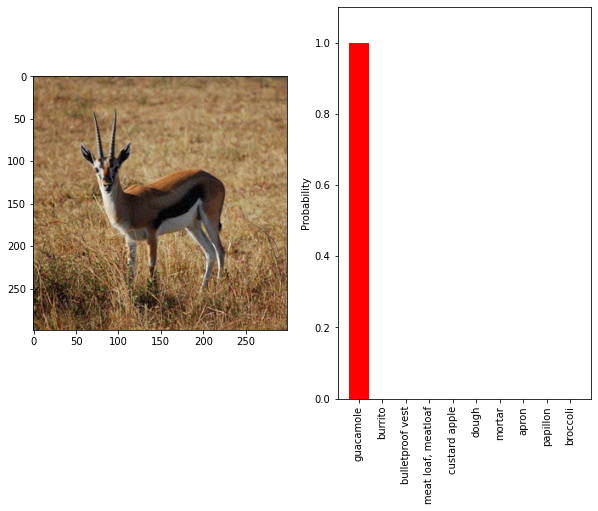

In [11]:
y_pred_adv = classifier.predict(x_adv)
# Evaluate results
plot_prediction(np.squeeze(x_adv), y_pred_adv, correct_class=y, target_class=y_target)

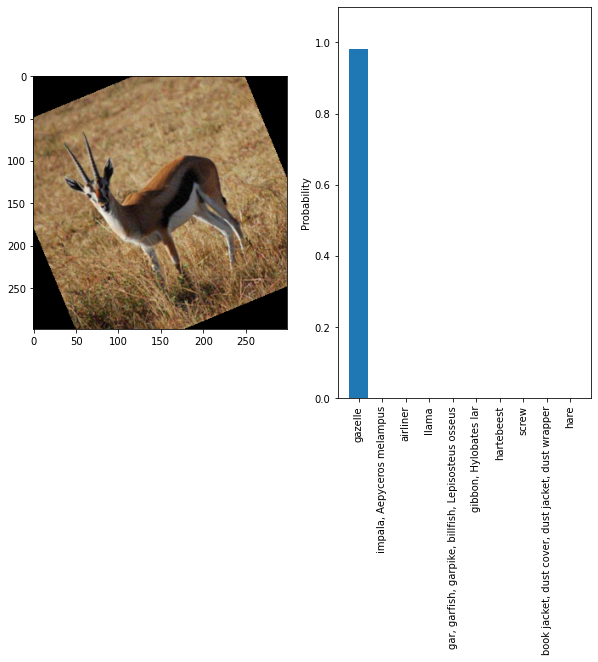

In [12]:
x_adv_rotated = scipy.ndimage.rotate(x_adv, angle=angle_max, reshape=False, axes=(1, 2), order=1)
# Get predictions on adversarial examples
y_pred_adv_rotated = classifier.predict(x_adv_rotated)
# Evaluate results
plot_prediction(x_adv_rotated[0], y_pred_adv_rotated, correct_class=y, target_class=y_target)

## There are Adversarial attacks, robust against rotation:

In [13]:
eot_rotation = EoTImageRotationTensorFlow(nb_samples=eot_samples,
                                          clip_values=clip_values,
                                          angles=eot_angle)
classifier_eot = TensorFlowV2Classifier(model=model,
                                        nb_classes=nb_classes,
                                        loss_object=loss,
                                        preprocessing=preprocessing,
                                        preprocessing_defences=[eot_rotation],
                                        clip_values=clip_values,
                                        input_shape=input_shape)
attack_eot = ProjectedGradientDescent(estimator=classifier_eot,
                                      eps=eps,
                                      max_iter=num_steps,
                                      eps_step=eps_step,
                                      targeted=True)

In [14]:
# Generate adversarial examples
x_adv_eot = attack_eot.generate(x=x, y=y_target)

In [67]:
def randomscale(img, maxzoom,maxoffset):
  
  #OCTAVE_SCALE = 1.30
  original_img = img.copy()
  img = tf.constant(np.array(original_img))
  base_shape = tf.shape(img)[:-1]
  float_base_shape = tf.cast(base_shape, tf.float32)
  offset_height = tf.random.uniform(shape = [1,1],minval=1, maxval=maxoffset, dtype=tf.dtypes.float32, seed=None, name=None)
  offset_width = tf.random.uniform(shape = [1,1],minval=1, maxval=maxoffset, dtype=tf.dtypes.float32, seed=None, name=None)
  n = tf.random.uniform(shape = [1,1],minval=1.1, maxval=maxzoom, dtype=tf.dtypes.float32, seed=None, name=None)
  print(int(offset_width))
#for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(n), tf.int32)
  print(new_shape[0][1:])
  img = tf.image.resize(img, new_shape[0][1:]).numpy()
  a = tf.image.crop_to_bounding_box(img, int(offset_height), int(offset_width), 299, 299)
  return a

6
tf.Tensor([377 377], shape=(2,), dtype=int32)


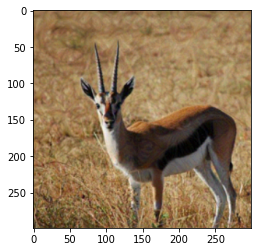

In [73]:
scaled = randomscale(x_adv_eot,3,50)
plt.imshow(scaled[0])



iteration 5
2
tf.Tensor([403 403], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


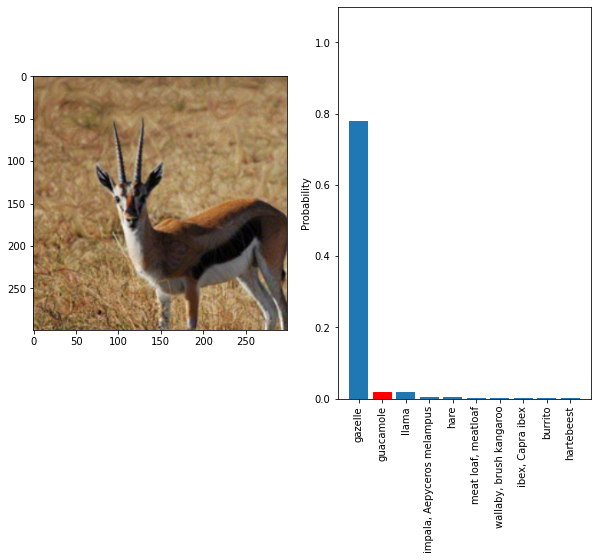

iteration 6
3
tf.Tensor([410 410], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


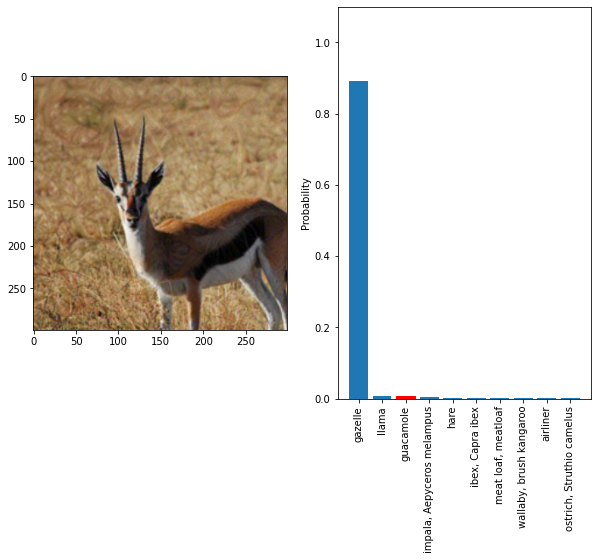

iteration 7
5
tf.Tensor([348 348], shape=(2,), dtype=int32)
tf.Tensor(924, shape=(), dtype=int64)


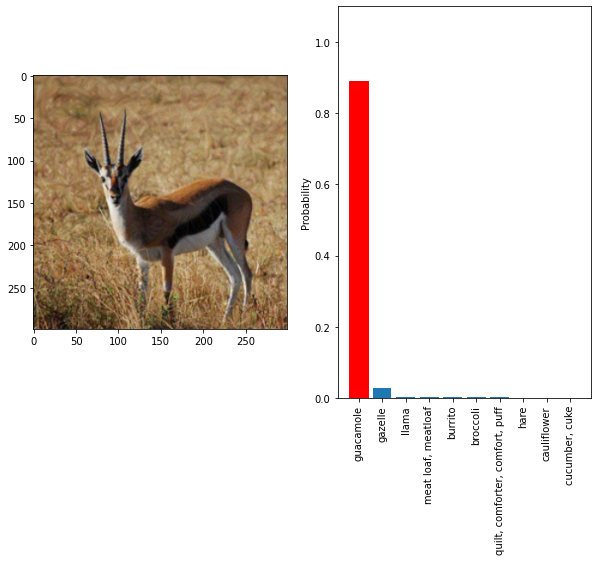

iteration 8
6
tf.Tensor([391 391], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


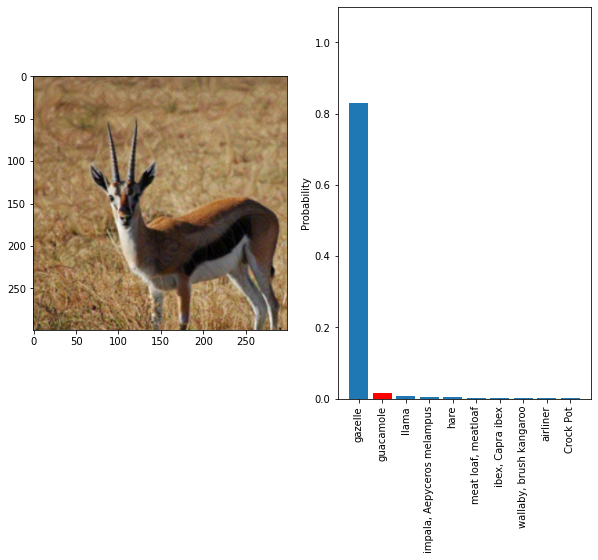

iteration 9
3
tf.Tensor([460 460], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


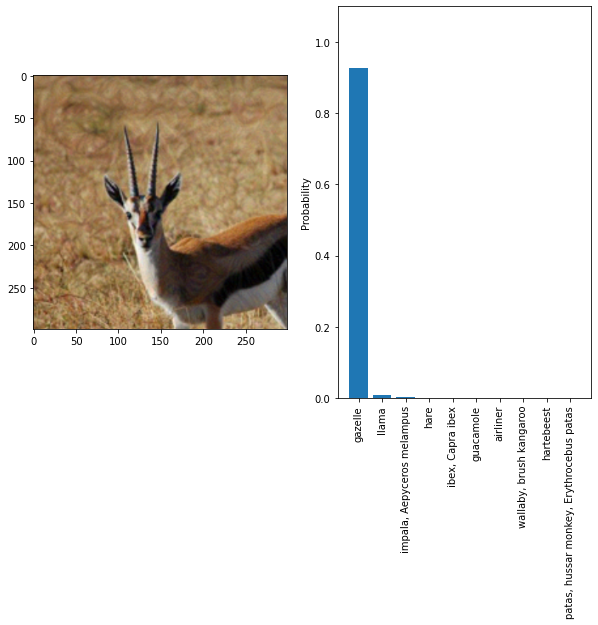

iteration 10
5
tf.Tensor([552 552], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


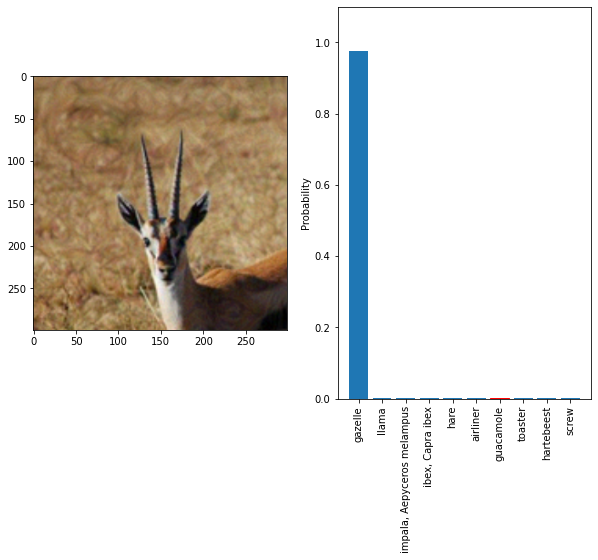

iteration 11
5
tf.Tensor([397 397], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


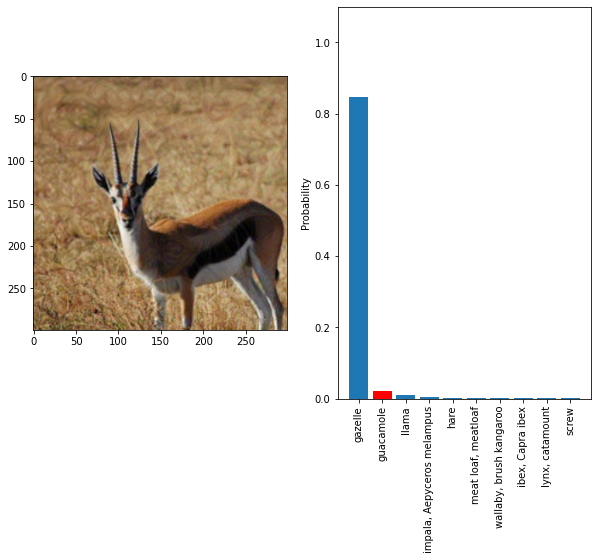

iteration 12
8
tf.Tensor([482 482], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


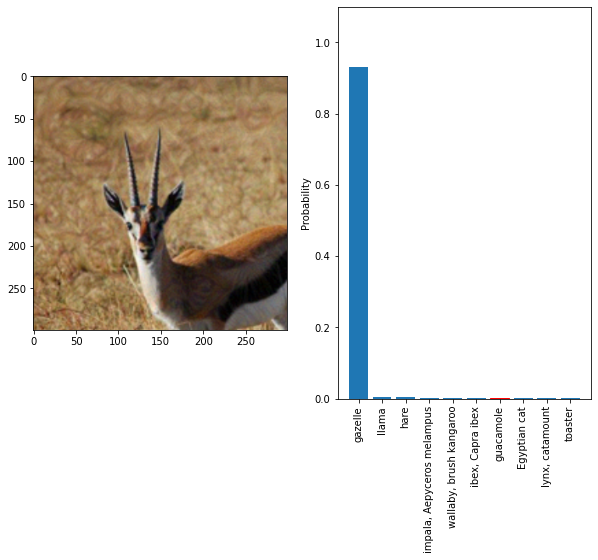

iteration 13
1
tf.Tensor([524 524], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


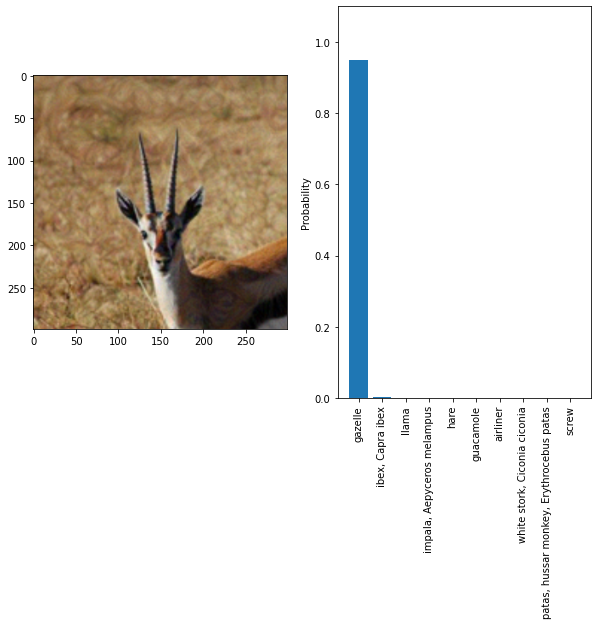

iteration 14
7
tf.Tensor([625 625], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


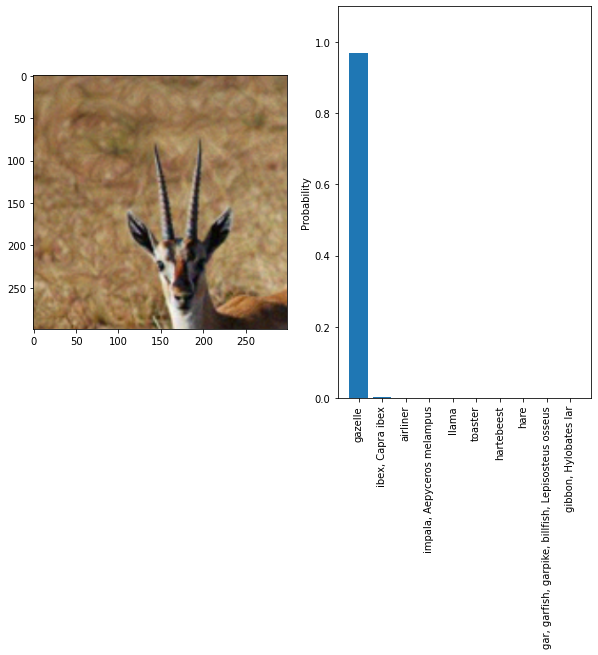

iteration 15
4
tf.Tensor([461 461], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


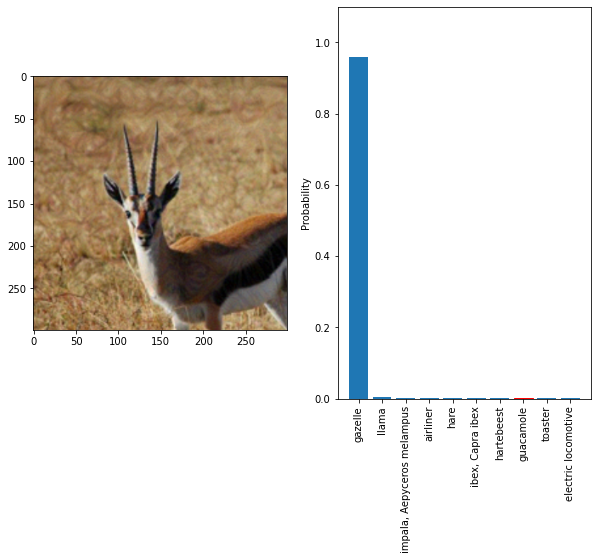

iteration 16
5
tf.Tensor([596 596], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


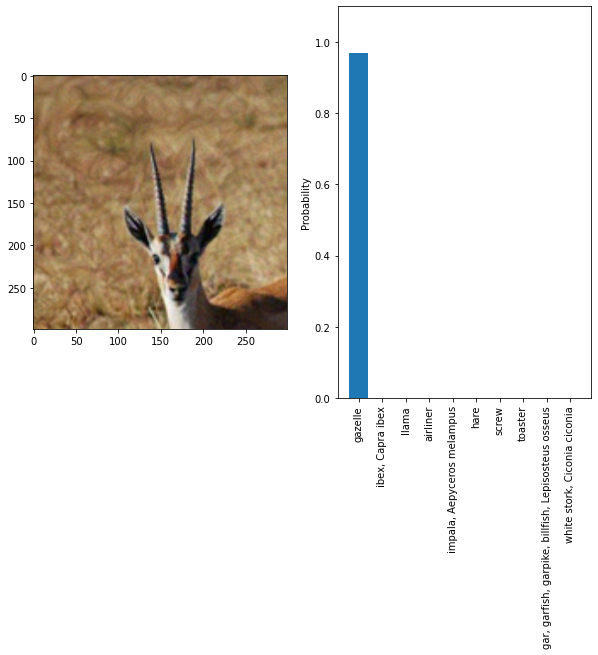

iteration 17
5
tf.Tensor([564 564], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


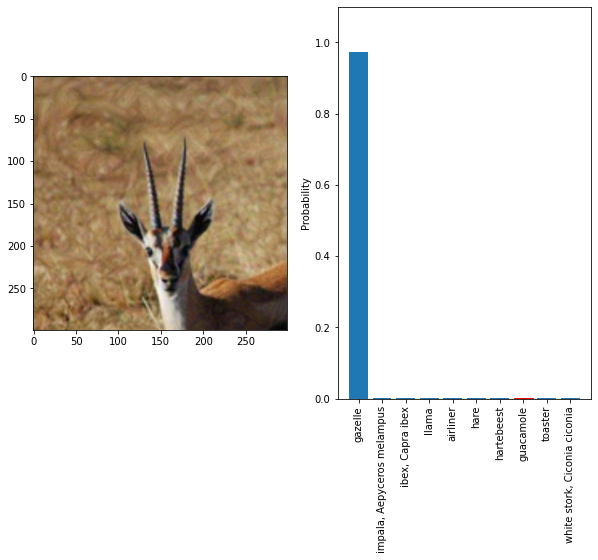

iteration 18
1
tf.Tensor([751 751], shape=(2,), dtype=int32)
tf.Tensor(353, shape=(), dtype=int64)


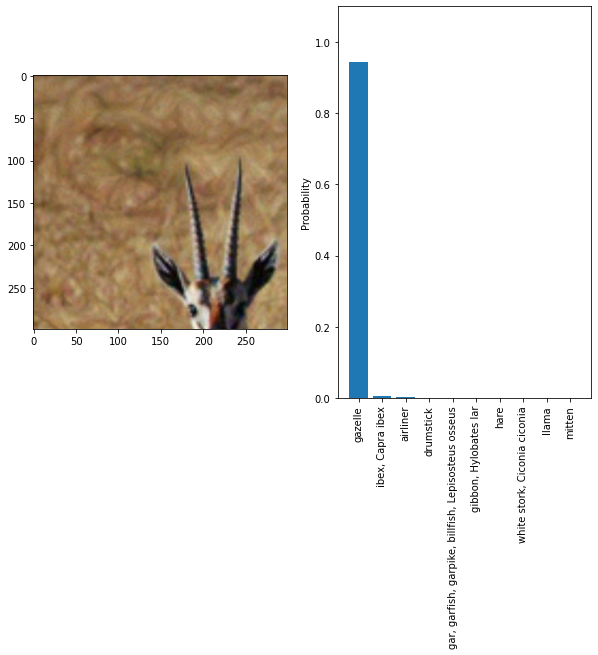

iteration 19
7
tf.Tensor([366 366], shape=(2,), dtype=int32)
tf.Tensor(924, shape=(), dtype=int64)


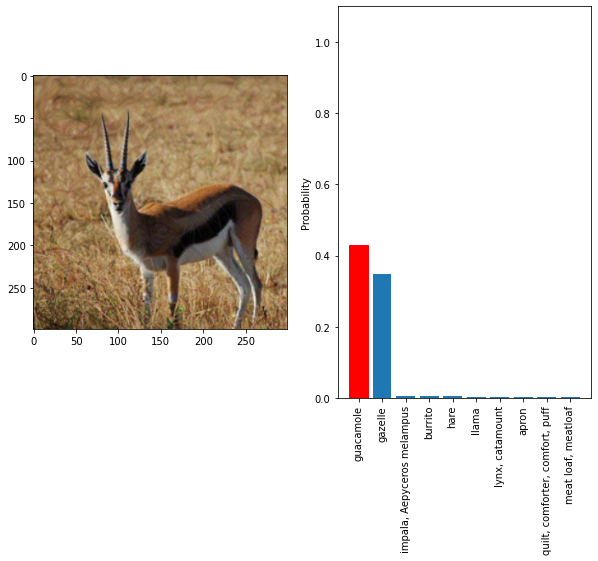

In [76]:
# Evaluate results for adversarial example rotated by various angles
#for angle_i in [-22.5, -5.0, 0.0, 5.0, 22.5]:
    #print("Rotation angle:", angle_i)
for i in range(5,20):    
    # Rotate adversarial example
    #x_adv_eot_rotated = scipy.ndimage.rotate(x_adv_eot, angle_i, reshape=False, axes=(1, 2), order=1)
    print("iteration",i)
    x_adv_eot_transformed = randomscale(x_adv_eot, 1+i/10,10)
    # Get predictions on adversarial examples using the classifier without EoT
    y_pred_adv_eot_transformed = classifier.predict(x_adv_eot_transformed)
    #y_pred_adv_eot_rotated = classifier.predict(x_adv_eot_rotated)
    print(tf.math.argmax(y_pred_adv_eot_transformed[0]))
    # Evaluate results
    plot_prediction(x_adv_eot_transformed[0], y_pred_adv_eot_transformed, correct_class=y, target_class=y_target)

In [ ]:
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    im = tf.keras.preprocessing.image.img_to_array(im)
    if 'tractor.jpg' in image_path:
        x = np.array(im)
x = (np.expand_dims(x, axis=0) / 255.0).astype(np.float32)
y = np.array([name_to_label("tractor")])

In [ ]:
import torch
import torchvision.transforms as transforms

def set_transforms(degrees, translate):
  my_transforms = transforms.Compose([
    transforms.RandomAffine(degrees = degrees, translate = translate)
    #transforms.RandomHorizontalFlip(p = 0.3)
    ])



In [ ]:
# Generate adversarial examples
x_adv_eot = attack_eot.generate(x=x, y=y_target)


AttributeError: ignored

In [36]:
import torch
import torchvision.transforms as transforms


def set_transforms(_,degrees, translate):
  my_transforms = transforms.Compose([
    transforms.RandomAffine(degrees = degrees, translate = translate)
    #transforms.RandomHorizontalFlip(p = 0.3)
    ])

# Generate adversarial examples
x_adv_eot = attack_eot.generate(x=x, y=y_target)
#adv_eot = torch.from_numpy(x_adv_eot)

NameError: ignored

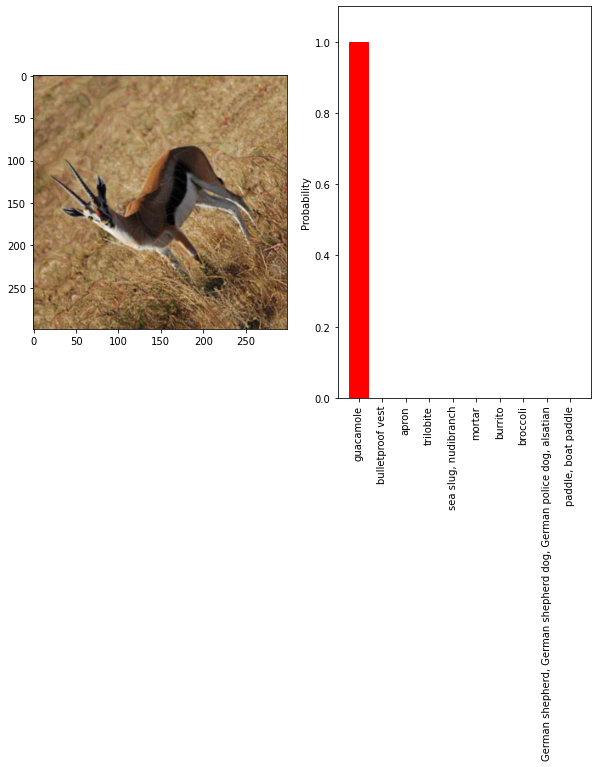

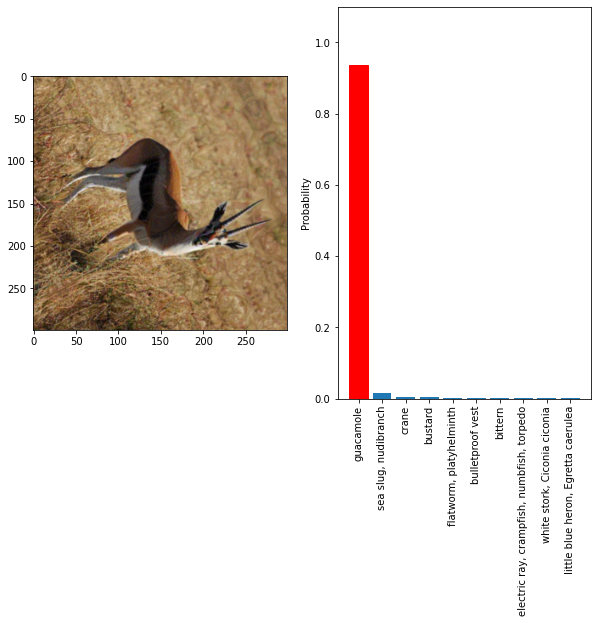

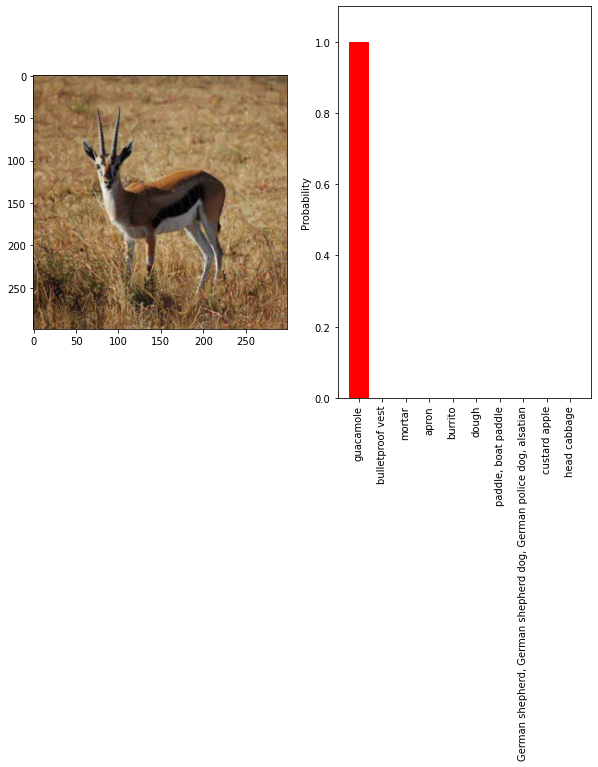

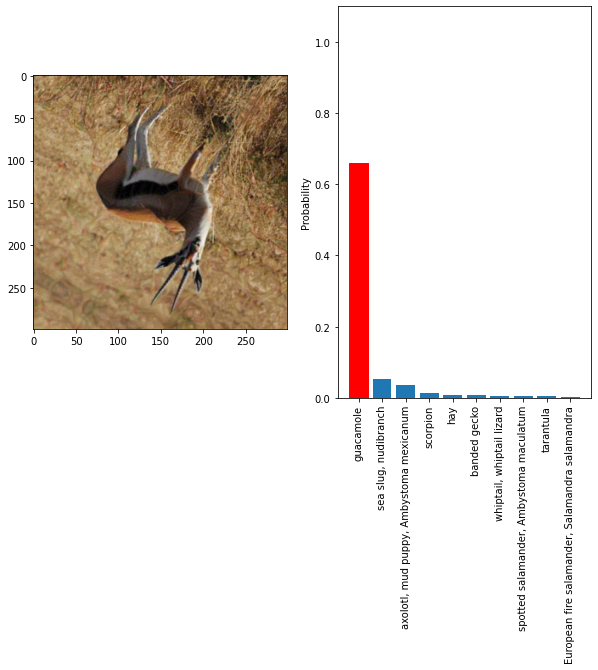

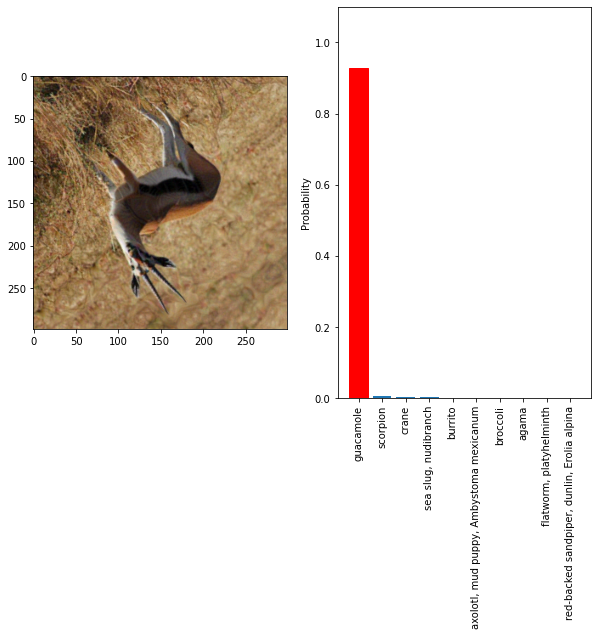

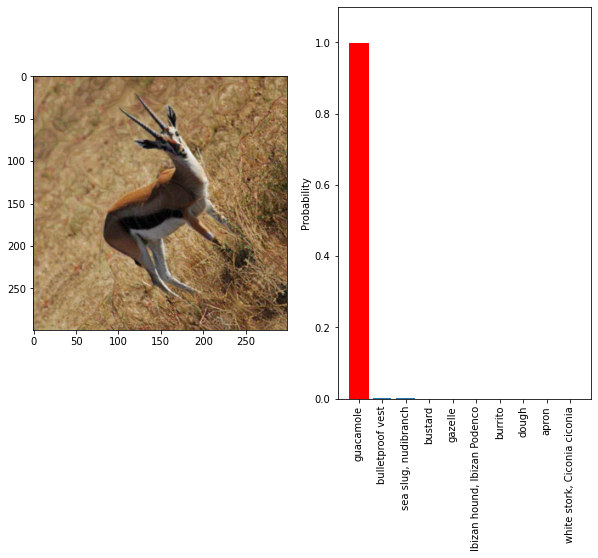

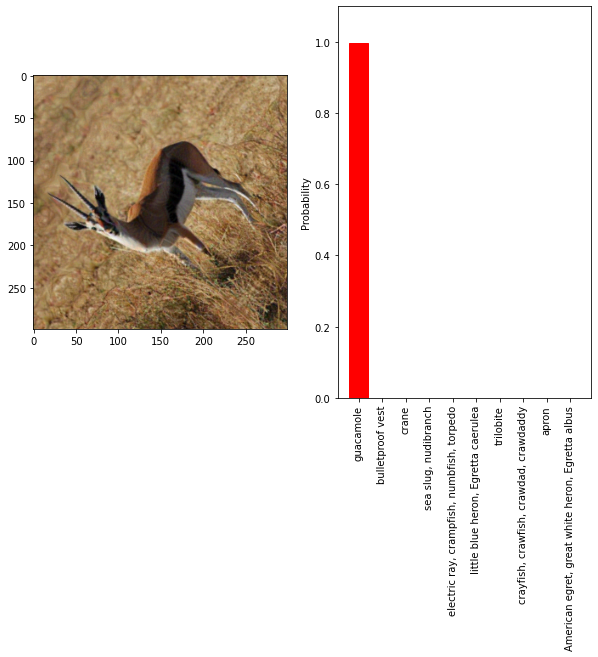

In [46]:
from tensorflow.keras import layers
# Evaluate results for adversarial example rotated by various angles
for brightness in [ 0.0,0.1,0.2,0.3,0.4,0.5,0.6]:

    #for translate in [(0,0), (0.1,0.1), (0.3, 0.3), (0.5,0.5)]:
    #print("Rotation angle:", angle_i)#,"translation:", translate)
  #my_transforms = transforms.Compose([transforms.RandomAffine(degrees = angle_i, translate = translate)])
    #my_transforms = transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0)
    data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), layers.experimental.preprocessing.RandomRotation(0.2),])
  # Transformed adversarial example
    x_adv_eot_transformed = data_augmentation(x_adv_eot)
    #x_adv_eot_transformed = my_transforms(adv_eot)#,degrees = angle_i, translate = translate)
      #x_adv_eot_rotated = scipy.ndimage.rotate(x_adv_eot, angle_i, reshape=False, axes=(1, 2), order=1)
        # Get predictions on adversarial examples using the classifier without EoT
    y_pred_adv_eot_transformed = classifier.predict(x_adv_eot_transformed.numpy())
        # Evaluate results
    plot_prediction(x_adv_eot_transformed[0].numpy(), y_pred_adv_eot_transformed, correct_class=y, target_class=y_target)

#Rotation Only


In [2]:
classifier = TensorFlowV2Classifier(model=model,
                                    nb_classes=nb_classes,
                                    loss_object=loss,
                                    preprocessing=preprocessing,
                                    preprocessing_defences=None,
                                    clip_values=clip_values,
                                    input_shape=input_shape)


eot_rotation = EoTImageRotationTensorFlow(nb_samples=eot_samples,
                                          clip_values=clip_values,
                                          angles=eot_angle)
classifier_eot = TensorFlowV2Classifier(model=model,
                                        nb_classes=nb_classes,
                                        loss_object=loss,
                                        preprocessing=preprocessing,
                                        preprocessing_defences=[eot_rotation],
                                        clip_values=clip_values,
                                        input_shape=input_shape)
attack_eot = ProjectedGradientDescent(estimator=classifier_eot,
                                      eps=eps,
                                      max_iter=num_steps,
                                      eps_step=eps_step,
                                      targeted=True)

adv_eot = torch.from_numpy(x_adv_eot)

for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    im = tf.keras.preprocessing.image.img_to_array(im)
    if 'cat.jpg' in image_path:
        x = np.array(im)
x = (np.expand_dims(x, axis=0) / 255.0).astype(np.float32)
y = np.array([name_to_label("tractor")])

NameError: ignored